In [71]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

In [72]:
code_dir=Path.cwd()
project_dir=code_dir.parent
input_dir=project_dir/"input"
output_dir=project_dir/"output/index_comparison"
tmp_dir=project_dir/"tmp"
Path(output_dir).mkdir(exist_ok=True)

In [73]:
maps = list(Path(input_dir/"cortical_maps").glob("*csv"))

In [75]:
def perform_spins(meas, reference_meas):

    import numpy as np
    from scipy.stats import spearmanr
    from enigmatoolbox.permutation_testing import spin_test

    # Perform spatial correlations
    fin_idx = np.isfinite(meas) & np.isfinite(reference_meas)
    r = spearmanr(meas[fin_idx], reference_meas[fin_idx])[0]
    p, d = spin_test(meas, reference_meas, surface_name='fsa5', parcellation_name=f'schaefer_400',
                                type='spearman', n_rot=1000, null_dist=True)

    return r, p, d

In [76]:
from neuromaps.parcellate import Parcellater
from netneurotools import datasets as nntdata
from neuromaps.images import dlabel_to_gifti

schaefer = nntdata.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
parc = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')

maps_fslr_dict = dict()
maps_dict = dict()
for map in maps:
    thickness_data_array = pd.read_csv(map, header=0).drop("Unnamed: 0", axis=1).values
    if "t_values" in str(map.name):
        maps_dict[map.name] = parc.fit_transform(thickness_data_array.squeeze(), 'fsLR')
    else:
        maps_dict[map.name] = thickness_data_array.flatten() 

maps_dict = {k.split(".")[0]: v for k, v in maps_dict.items()}

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [77]:
from enigmatoolbox.datasets import load_fc
_, schaefer_labels, _, _ = load_fc(parcellation=f'schaefer_400')


In [78]:
maps_df = pd.DataFrame(maps_dict, index=schaefer_labels)
maps_df = maps_df[maps_df.columns.sort_values()]

maps_fslr_df = pd.DataFrame(maps_fslr_dict)
maps_fslr_df = maps_fslr_df[maps_fslr_df.columns.sort_values()]

In [79]:
maps_df.to_csv(output_dir/"effect_maps_schaefer400.csv")
maps_fslr_df.to_csv(output_dir/"effect_maps_fslr.csv")

In [82]:
df_cols = ['pls_combined_bootstrap_df', 'pls_ukb_bootstrap_df', 'pls_hchs_bootstrap_df', 't_values_combined']
df_cols_styled = [ 'PLS UKB/HCHS (bootstrap ratio)','PLS UKB (bootstrap ratio)', 'PLS HCHS (bootstrap ratio)', 'Group comparison UKB/HCHS (t-value)',]
styling_dict = dict(zip(df_cols, df_cols_styled))

In [ ]:
import itertools
result_dictionary = dict()
combinations = list(itertools.combinations(df_cols, 2))
length_combinations = len(combinations)
for idx, (map_a, map_b) in enumerate(combinations):
    
    print(f"{idx+1}/{length_combinations}")
    r, p, d = perform_spins(
    meas = maps_dict[map_a],
    reference_meas = maps_dict[map_b])
    analysis = str(map_a) + str(map_b)
    result_dictionary[analysis] = (r,p,d,str(map_a),str(map_b),maps_dict[map_a],maps_dict[map_b])

In [66]:
maps_df = pd.DataFrame(maps_dict)

/home/marvin/miniconda3/envs/brainstat/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/marvin/miniconda3/envs/brainstat/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/marvin/miniconda3/envs/brainstat/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a fi

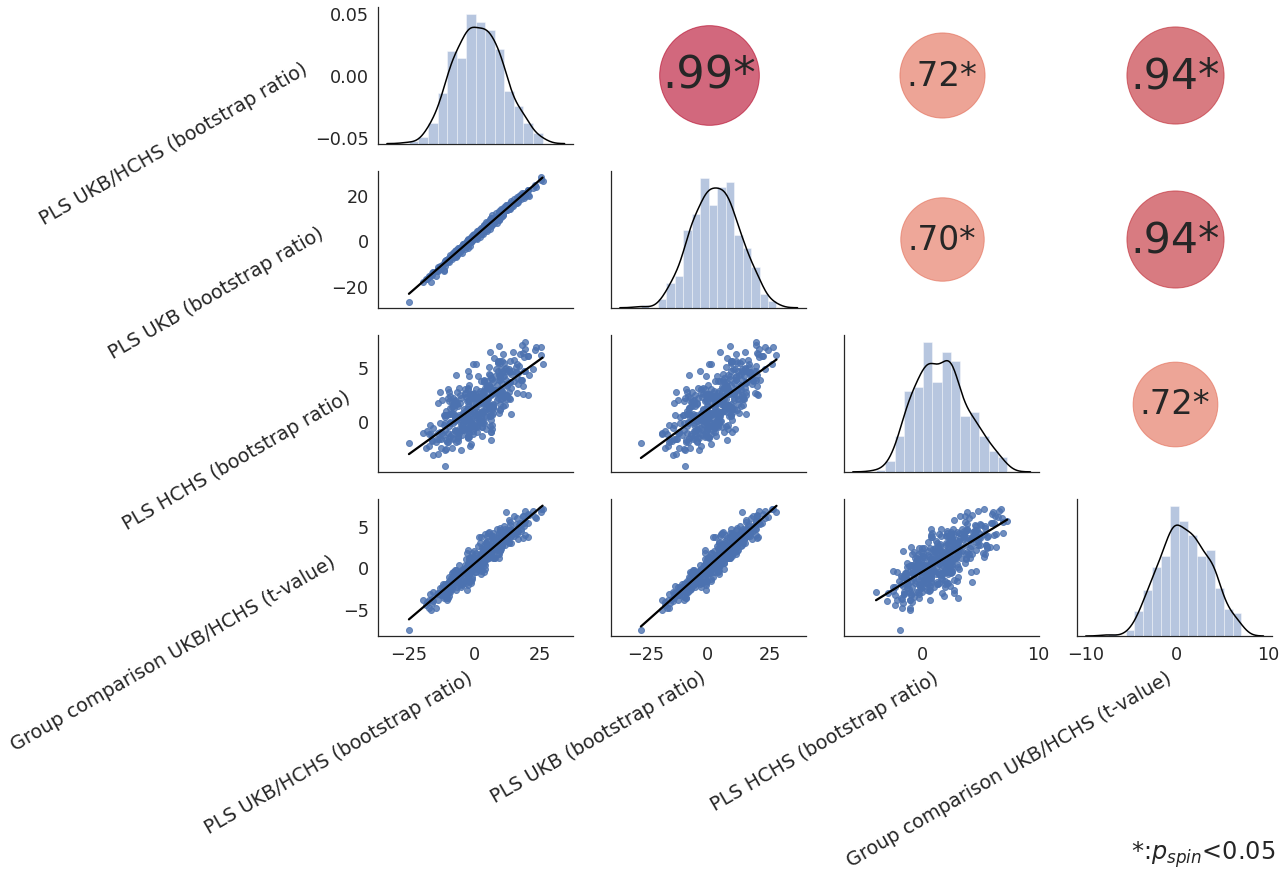

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson') 
    corr_text = f"{corr_r:2.2f}*".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='white', font_scale=1.6)
df = maps_df[df_cols].copy()
df.rename(columns=styling_dict, inplace=True)

g = sns.PairGrid(df, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=False, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)

for ax in g.axes.flatten():
    ax.set_ylabel(ax.get_ylabel(), rotation = 30)
    ax.set_xlabel(ax.get_xlabel(), rotation = 30, ha='right')
    ax.yaxis.get_label().set_horizontalalignment('right')

plt.text(-5,-40, f"*:$p_{{spin}}$<0.05", ha="left", size=24)

plt.savefig(output_dir/"index_comparison.png", dpi=300, bbox_inches='tight')